In [1]:
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from avalanche.models import SlimResNet18
from avalanche.benchmarks import with_task_labels, benchmark_from_datasets
from OCL.utils import load_CLEAR, build_CLEAR_train_experiences, build_CLEAR_test_experiences
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import forgetting_metrics, \
accuracy_metrics, loss_metrics
from avalanche.benchmarks.scenarios.online import split_online_stream
from OCL.plugins import create_strategy
from avalanche.training.templates import SupervisedTemplate


/Users/marcodamommio/2023-2024_OCL_Class-Incremental/sda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
CLEAR_transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((32, 32)),
            #normalize,
        ]
    )
train_path = '/Users/marcodamommio/2023-2024_OCL_Class-Incremental/train/labeled_images'
test_path = '/Users/marcodamommio/2023-2024_OCL_Class-Incremental/test/labeled_images'
train_dict = load_CLEAR(train_path, transform=CLEAR_transform)
test_dict = load_CLEAR(test_path, transform=CLEAR_transform)

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


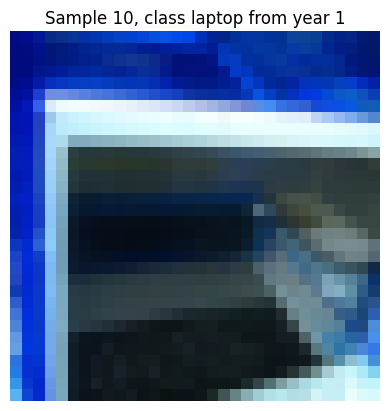

In [3]:
year_folder_name = '1'
class_folder_name = 'laptop'
images_array = test_dict[year_folder_name][class_folder_name]

elem = 10
plt.imshow(images_array[elem].permute(1,2,0))
plt.axis('off') 
plt.title(f'Sample {elem}, class {class_folder_name} from year {year_folder_name}')
plt.show()

In [4]:
classes_pairs = [
    ('BACKGROUND', 'baseball'),
    ('bus', 'camera'),
    ('cosplay', 'dress'),
    ('hockey', 'laptop'),
    ('racing', 'soccer'),
    ('sweater', None)   
]

In [5]:
# If all the data were used
n_years = len(train_dict.keys())
n_classes = len(train_dict[year_folder_name])
n_images = train_dict[year_folder_name][class_folder_name].shape[0]
tot_training_size = n_years * n_classes * n_images
mb_size = 10
tot_train_steps = int(tot_training_size / mb_size)

# Each experience contains 2 classes, except for the last one (odd number of experiences)
experience_size = 2 * n_years * n_images
experience_steps = int(experience_size / mb_size) 

print(f"Number of years is {n_years}")
print(f"Number of classes for each year is {n_classes}")
print(f"Number of images in each pair year-class: {n_images}")
print(f"Total number of training data: {tot_training_size}")
print(f"Total number of training steps: {tot_train_steps}")
print(f"Total number of samples for a complete experience: {experience_size}")
print(f"Total number of steps in a complete experience: {experience_steps}")
print(f"Total number of samples for the last complete experience: {int(experience_size / 2)}")
print(f"Total number of steps for the last complete experience: {int(experience_steps / 2)}")


Number of years is 10
Number of classes for each year is 11
Number of images in each pair year-class: 300
Total number of training data: 33000
Total number of training steps: 3300
Total number of samples for a complete experience: 6000
Total number of steps in a complete experience: 600
Total number of samples for the last complete experience: 3000
Total number of steps for the last complete experience: 300


In [6]:
# By subsampling, we take 'subsample' examples by each set of (Year, Class).
# Then the subsample obtained is shuffled, so that is class balanced in expectation. 
subsample_size = 25
train_experiences = build_CLEAR_train_experiences(train_dict, classes_pairs, subsample=subsample_size)
test_experiences = build_CLEAR_test_experiences(test_dict, classes_pairs)

In [7]:
# Repeat the computation of size/steps for subsampled dataset
subsampled_training_size = n_years * n_classes * subsample_size
subsampled_train_steps = int(subsampled_training_size / mb_size)
subsampled_experience_size = 2 * n_years * subsample_size
subsampled_experience_steps = int(subsampled_experience_size / mb_size) 

print(f"Number of images subsampled in each pair year-class: {subsample_size}")
print(f"Number of subsampled training data: {subsampled_training_size}")
print(f"Size for a subsampled experience: {subsampled_experience_size}")
print(f"Number of training steps for a subsampled experience: {subsampled_experience_steps}")
print(f"Size for the last subsampled experience: {int(subsampled_experience_size/2)}")
print(f"Number of training steps for the last subsampled experience: {int(subsampled_experience_steps/2)}")

Number of images subsampled in each pair year-class: 25
Number of subsampled training data: 2750
Size for a subsampled experience: 500
Number of training steps for a subsampled experience: 50
Size for the last subsampled experience: 250
Number of training steps for the last subsampled experience: 25


In [8]:
# Create the benchmark
bm = with_task_labels(
    benchmark_from_datasets(
        train=train_experiences,
        test = test_experiences
    ) 
)

In [9]:
print(f"Number of experiences in the train_stream {len(bm.train_stream)}")
print(f"Number of samples in each experience {len(bm.train_stream[0].dataset)}")
print(f"Number of samples in each experience {len(bm.train_stream[5].dataset)}")

Number of experiences in the train_stream 6
Number of samples in each experience 500
Number of samples in each experience 250


In [10]:
# Create the online stream 
experience_mb_size = 10
online_train_stream = split_online_stream(
    bm.train_stream,
    experience_size=experience_mb_size,
    shuffle=False
)

In [11]:
# Set the model, loss and optimizer
model = SlimResNet18(nclasses=11, nf=5)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
)

/Users/marcodamommio/2023-2024_OCL_Class-Incremental/sda/lib/python3.11/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


In [12]:
# Choose the Continual Learning strategy plugins among "er", "lwf", "er_lwf", "agem", "cwr", "naive"
CL_PLUGIN_NAME = "cwr"
strategy_kwargs = {
    "model": model,
    "mem_size": 500,
    "sample_size": 200,
    "alpha": 1, 
    "temperature": 2,
    "batch_size_mem": 20,
    "freeze_remaining_model": True
    
}
plugins = create_strategy(
    name=CL_PLUGIN_NAME,
    strategy_kwargs=strategy_kwargs)

In [13]:
cl_strategy = SupervisedTemplate(
    model=model, 
    optimizer=optimizer, 
    criterion=criterion,
    train_mb_size=experience_mb_size,
    train_epochs=1, 
    eval_mb_size=64,
    evaluator=eval_plugin,
    plugins=plugins
)

In [14]:
# TRAINING LOOP
print('Starting experiment...')
results = []
idx = 0
for experience in online_train_stream:
    print("Start of experience: ", experience.current_experience)
    print(f"\tsize: {len(experience.dataset)}")
    cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(bm.test_stream))
    idx += 1

Starting experiment...
Start of experience:  0
	size: 10
Training completed
Computing accuracy on the whole test set
Start of experience:  1
	size: 10
Training completed
Computing accuracy on the whole test set
Start of experience:  2
	size: 10
Training completed
Computing accuracy on the whole test set
Start of experience:  3
	size: 10
Training completed
Computing accuracy on the whole test set
Start of experience:  4
	size: 10
Training completed
Computing accuracy on the whole test set
Start of experience:  5
	size: 10
Training completed
Computing accuracy on the whole test set
Start of experience:  6
	size: 10
Training completed
Computing accuracy on the whole test set
Start of experience:  7
	size: 10
Training completed
Computing accuracy on the whole test set
Start of experience:  8
	size: 10
Training completed
Computing accuracy on the whole test set
Start of experience:  9
	size: 10
Training completed
Computing accuracy on the whole test set
Start of experience:  10
	size: 10
Tr

In [20]:
metrics = eval_plugin.get_all_metrics()

In [21]:
print('\n'.join(list(metrics.keys())))

Top1_Acc_MB/train_phase/train_online_stream
Loss_MB/train_phase/train_online_stream
Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000
Loss_Exp/eval_phase/test_stream/Task000/Exp000
Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001
Loss_Exp/eval_phase/test_stream/Task001/Exp001
Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002
Loss_Exp/eval_phase/test_stream/Task002/Exp002
Top1_Acc_Exp/eval_phase/test_stream/Task003/Exp003
Loss_Exp/eval_phase/test_stream/Task003/Exp003
Top1_Acc_Exp/eval_phase/test_stream/Task004/Exp004
Loss_Exp/eval_phase/test_stream/Task004/Exp004
Top1_Acc_Exp/eval_phase/test_stream/Task005/Exp005
Loss_Exp/eval_phase/test_stream/Task005/Exp005
Top1_Acc_Stream/eval_phase/test_stream/Task005
Loss_Stream/eval_phase/test_stream/Task005
StreamForgetting/eval_phase/test_stream
ExperienceForgetting/eval_phase/test_stream/Task000/Exp000
ExperienceForgetting/eval_phase/test_stream/Task001/Exp001
ExperienceForgetting/eval_phase/test_stream/Task002/Exp002
ExperienceForgetting/

In [22]:
accuracies = {
    f"accuracy_task_{i}": 
        metrics[f'Top1_Acc_Exp/eval_phase/test_stream/Task00{i}/Exp00{i}'][1] for i in range(6)
}
accuracies = pd.DataFrame(accuracies)
print(accuracies.shape)
accuracies.tail(60)

(275, 6)


,accuracy_task_0,accuracy_task_1,accuracy_task_2,accuracy_task_3,accuracy_task_4,accuracy_task_5
215,0.0,0.0,0.0,1.0,0.0,0.0
216,0.0,0.0,0.0,1.0,0.0,0.0
217,0.0,0.0,0.0,1.0,0.0,0.0
218,0.0,0.0,0.0,1.0,0.0,0.0
219,0.0,0.0,0.0,1.0,0.0,0.0
220,0.0,0.0,0.0,1.0,0.0,0.0
221,0.0,0.0,0.0,1.0,0.0,0.0
222,0.0,0.0,0.0,1.0,0.0,0.0
223,0.0,0.0,0.0,1.0,0.0,0.0
224,0.0,0.0,0.0,1.0,0.0,0.0


In [23]:
accuracies.to_csv("data/cwr_subsampling_25_yes_freeze.csv", index=False)